In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [4]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
yen_futures['returns'] = yen_futures['Settle'].pct_change()*100
yen_futures.replace('inf',value='NaN',inplace=True)
yen_futures.dropna(inplace=True)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,returns
Date,,,,,,,,,
2014-02-18,9831.0,9865.0,9734.0,9775.0,42.0,9775.0,203495.0,196924.0,-0.427829
2014-02-19,9768.0,9825.0,9760.0,9773.0,2.0,9773.0,129508.0,197197.0,-0.020460
2014-02-20,9774.0,9837.0,9765.0,9775.0,2.0,9775.0,160202.0,198280.0,0.020465
2014-02-21,9772.0,9776.0,9725.0,9758.0,20.0,9755.0,103091.0,202990.0,-0.204604
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0,0.020502


### Lagged Returns 

In [5]:
# Create a lagged return using the shift function
yen_futures['Lagged_Return'] = yen_futures['returns'].shift()
# Drop NaN values
yen_futures = yen_futures.dropna()
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,returns,Lagged_Return
Date,,,,,,,,,,
2014-02-19,9768.0,9825.0,9760.0,9773.0,2.0,9773.0,129508.0,197197.0,-0.020460,-0.427829
2014-02-20,9774.0,9837.0,9765.0,9775.0,2.0,9775.0,160202.0,198280.0,0.020465,-0.020460
2014-02-21,9772.0,9776.0,9725.0,9758.0,20.0,9755.0,103091.0,202990.0,-0.204604,0.020465
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0,0.020502,-0.204604
2014-02-25,9760.0,9808.0,9744.0,9789.0,32.0,9789.0,105498.0,201486.0,0.327970,0.020502


### Train Test Split

In [6]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_futures[:'2018']
test = yen_futures['2018':]

In [7]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train['Lagged_Return'].to_frame()
X_test = test['Lagged_Return'].to_frame()
y_train = train['returns'].to_frame()
y_test = test['returns'].to_frame()

In [8]:
X_train

,Lagged_Return
Date,
2014-02-19,-0.427829
2014-02-20,-0.020460
2014-02-21,0.020465
2014-02-24,-0.204604
2014-02-25,0.020502
...,...
2018-12-24,-0.187545
2018-12-26,0.834485
2018-12-27,-0.893346


# Linear Regression Model

In [9]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [10]:
# Make a prediction of "y" values using just the test dataset
predictions = model.predict(y_test)
predictions[:10]

array([[-0.0065973 ],
       [-0.00132512],
       [-0.00159424],
       [-0.00021283],
       [-0.00429076],
       [-0.00749427],
       [-0.01507303],
       [-0.00596728],
       [-0.00384555],
       [-0.01030224]])

In [11]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
yen_compare = pd.DataFrame()
yen_compare['Test']=y_test['returns']
yen_compare['Predicted']=predictions
yen_compare.head()

,Test,Predicted
Date,,
2018-01-02,0.297285,-0.006597
2018-01-03,-0.240479,-0.001325
2018-01-04,-0.213028,-0.001594
2018-01-05,-0.353933,-0.000213
2018-01-08,0.062017,-0.004291


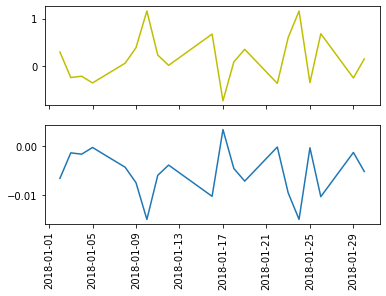

In [25]:
fig, ax = plt.subplots(2, 
           sharex='col', sharey='row',)

ax[0].plot(yen_compare['Test'][:20],c='y')

ax[1].plot(yen_compare['Predicted'][:20])

plt.xticks(rotation=90)

plt.show()

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [24]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(y_test, predictions)
# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.41949601440291095


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [26]:
predict_in=model.predict(y_train)

In [28]:
# y_train.head()

In [29]:
# Construct a dataframe using just the "y" training data:
yen_compare_train = pd.DataFrame()
yen_compare_train['Train']=y_train['returns']
yen_compare_train['Predicted']=predict_in
yen_compare_train.head()

,Train,Predicted
Date,,
2014-02-19,-0.020460,-0.003482
2014-02-20,0.020465,-0.003883
2014-02-21,-0.204604,-0.001677
2014-02-24,0.020502,-0.003884
2014-02-25,0.327970,-0.006898


In [30]:
# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse_train = mean_squared_error(y_train, predict_in)
# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
rmse_train = np.sqrt(mse_train)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {rmse_train}")

Out-of-Sample Root Mean Squared Error (RMSE): 0.5714459891210213


# Conclusions

YOUR CONCLUSIONS HERE!

~
Our RMSE value will be between 0 and 1, so with both the training data and the testing data so close to 0.5, this is a pretty bad model.